# Get list of German Law Journals from ZDB

We use the script [download-lobid-law-issn.sh](./scripts/download-lobid-law-issn.sh) to download [jsonl data](data/zdb/zdb-ger-law-issn-all.jsonl) of all journal records that have the DCC number 340 ("law") and the label "language:german". 

We further convert that very complex json data with [convert-jsonl-to-csv.sh](./scripts/convert-jsonl-to-csv.sh) to a more manageable [csv file](data/zdb/zdb-ger-law-issn.csv) containing only basic fields.

In [1]:
import pandas as pd
df = pd.read_csv("data/zdb/zdb-ger-law-issn.csv", encoding="utf-8")
print(f'The full dataset contains {len(df)} journal records')

The full dataset contains 7406 journal records


Re-process the jsonl with python to extract more detailed journal data for a given period

In [12]:
import json
from dateutil import parser

def filter_publications(path, first_date, last_date):
    result = []

    with open(path, 'r') as f:
        for line in f:
            data = json.loads(line)
            publication_list = data.get('publication', [])
            first_date_parsed = parser.parse(first_date).date()
            last_date_parsed = parser.parse(last_date).date()
            for publication in publication_list:
                # consider lastDateParsed as end date if not present
                end_date = publication.get('endDate', str(last_date_parsed))
                end_date_parsed = parser.parse(end_date).date()
                start_date = publication.get('startDate', '0001-01-01') 
                if start_date == "0000":
                    start_date = '0001-01-01'
                start_date_parsed = parser.parse(start_date).date()
                # check if journal was being published within the given period
                if start_date_parsed <= first_date_parsed and end_date_parsed >= last_date_parsed:
                    result.append(data)
                    break
    return result

start_date = '1945'
end_date='2024'
filtered_data = filter_publications('data/zdb/zdb-ger-law-issn-all.jsonl', start_date, end_date)
print(f'The dataset contains {len(filtered_data)} journal records for the time period {start_date} to {end_date}.')
with open('data/zdb/zdb-ger-law-issn-1945-2024.json', 'w', encoding='utf-8') as f:
    json.dump(filtered_data, f, indent=2, ensure_ascii=False)

The dataset contains 1692 journal records for the time period 1945 to 2024.


Save the filtered dataset to a csv file for easier handling

In [11]:
import pandas as pd
data = []
for row in filtered_data:
    data.append({
        'title': row.get('title'),
        'issn': ','.join(row.get('issn', [])),
        'alternativeTitle': '; '.join(row.get('alternativeTitle', []))
    })
df = pd.DataFrame(data)
df.to_csv('data/zdb/zdb-ger-law-issn-1945-2024.csv', index=None)
df

,title,issn,alternativeTitle
0,Gesetz- und Verordnungsblatt für Berlin,03439550,Gesetz- und Verordnungsblatt ( Hauptsacht. tei...
1,"Civil liberties and police, Deutsche Ausgabe :...",01721895,Civil liberties and police / Deutsche Ausgabe;...
2,"Deutsche Steuer-Zeitung, Ausgabe A",00120774,DStZ
3,Bundeswehrverwaltung,"00075957,00075957",BWV
4,Archiv für das Zivil- und Kriminalrecht der Kö...,"18660371,18660371",Archiv für das Civil- und Criminalrecht der Kö...
...,...,...,...
1687,DIN-Katalog für technische Regeln,07229313,Katalog für technische Regeln; Catalogue of te...
1688,Bayerische Verwaltungsblätter,"05225337,05225337",BayVbl
1689,Der Betrieb,"00059935,00059935",IBZ - Internationaler betriebswirtschaftlicher...
1690,Zeitschrift für schweizerisches Recht,"0254945X,0084540X",Revue de droit Suisse; Rivista di diritto sviz...


Now we turn the filtered data into a dataframe that counts how many publication existed in each particular year

In [15]:
import json
from dateutil import parser
import pandas as pd
import numpy as np

def collect_years(filtered_data, fist_year, last_year):
    years = []
    for data in filtered_data:
        publication_list = data.get('publication', [])

        for publication in publication_list:
            start_date = publication.get('startDate', '0001')
            if start_date == "0000":
                start_date = "0001"
            end_date = publication.get('endDate', '2100')
            start_year = parser.parse(start_date).year
            end_year = parser.parse(end_date).year
            years.extend(list(range(start_year, end_year+1)))

    years = [year for year in years if year >= fist_year and year <= last_year ]
    frequency = pd.Series(years).value_counts()
    df = frequency.reset_index()
    df.columns = ['year', 'number_of_journals']
    return df

with open('data/zdb/zdb-ger-law-issn-1945-2024.json', 'r') as f:
    filtered_data = json.load(f)
df = collect_years(filtered_data, 1945, 2023)
df.to_csv('data/zdb/zdb-ger-law-issn-1945-2023-years.csv', index=None)
df

,year,number_of_journals
0,2009,1073
1,2011,1071
2,2007,1069
3,2010,1069
4,2008,1068
...,...,...
74,1949,251
75,1948,235
76,1947,219
77,1946,201


We can then plot the number of German law journals existing in each year afte 1945

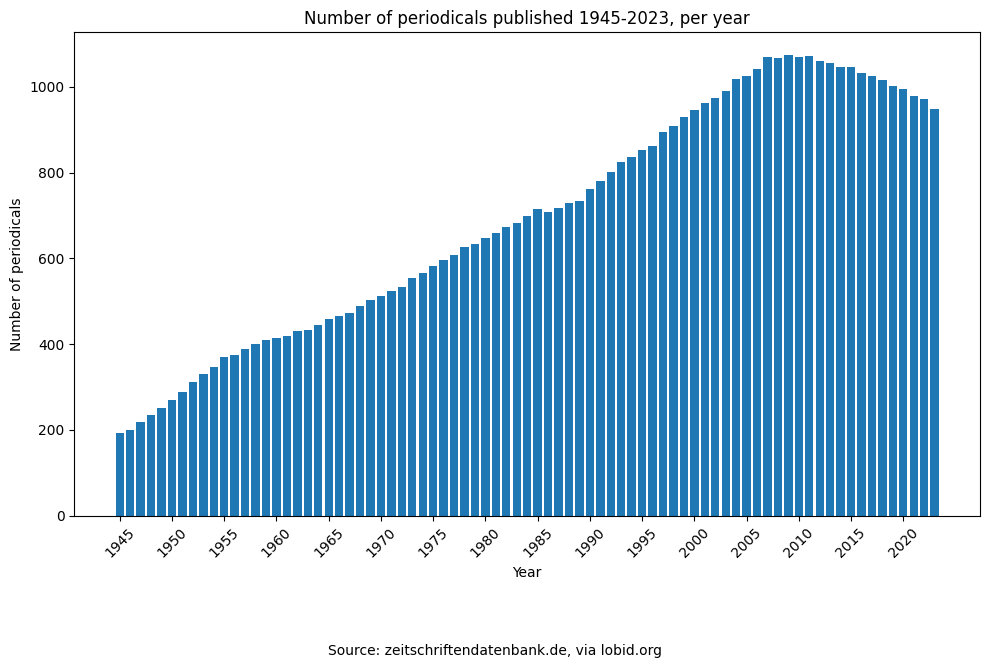

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(df['year'], df['number_of_journals'])
plt.xticks(df['year'][df['year'] % 5 == 0], rotation=45) # Label every 5th year on the x-axis.
plt.xlabel('Year')
plt.ylabel('Number of periodicals')
plt.title('Number of periodicals published 1945-2023, per year')
plt.figtext(0.5, -0.1, "Source: zeitschriftendatenbank.de, via lobid.org", ha="center", fontsize=10)
plt.tight_layout()
plt.savefig('plots/periodicals_published_timeline.png', dpi=300, bbox_inches='tight')
plt.show()

Finally, we generate a list of publication periods of each journal

In [5]:
import json
from dateutil import parser
import pandas as pd

rows = []
with open('data\zdb\zdb-ger-law-issn-all.jsonl', 'r') as f:
    for line in f:
        data = json.loads(line)
        pub_title = data.get('title')
        pub_abbr = next((x for x in data.get('alternativeTitle', []) if len(x) < 10), None) 
        if pub_abbr and len(pub_abbr) > 20:
            pub_abbr = None
        publication_periods = data.get('publication', [])
        for publication_period in publication_periods:
            # start
            start_date = publication_period.get('startDate') 
            if start_date is None or start_date == "0000":
                start_date = "0001"
            start_date_parsed = int(parser.parse(start_date).year) if start_date else None
            # end
            end_date = publication_period.get('endDate')
            end_date_parsed = int(parser.parse(end_date).year) if end_date else None
            rows.append([pub_title, pub_abbr, start_date_parsed, end_date_parsed])
            
df = pd.DataFrame(rows, columns=['name','abbr', 'year_start','year_end'])
df.to_csv('data/zdb/journal_publication_periods.csv', index=False)
df

,name,abbr,year_start,year_end
0,Gesetz- und Verordnungsblatt für Berlin,None,1990,NaN
1,Gesetz- und Verordnungsblatt für Berlin,None,2008,2008.0
2,Gesetz- und Verordnungsblatt für Berlin,None,2009,2010.0
3,Gesetz- und Verordnungsblatt für Berlin,None,2024,NaN
4,Hessen-Jahrbuch,None,2000,2009.0
...,...,...,...,...
10885,Zeitschrift für vergleichende Rechtswissenschaft,ZVglRWiss,2024,NaN
10886,Zeitschrift für vergleichende Rechtswissenschaft,ZVglRWiss,2024,NaN
10887,Die Sozialgerichtsbarkeit,SGb,1954,NaN
10888,Die Sozialgerichtsbarkeit,SGb,1954,2005.0
